In [53]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.optimize import curve_fit
import numpy as np
import cv2
import os

### Film Type & Color Channel

In [88]:
filmtype = "EBT4"
channel = "G"    #Choose G or RGB

### 1. Calibration Films - Intensity extraction

  Mean intensity square :  97.03513095238095


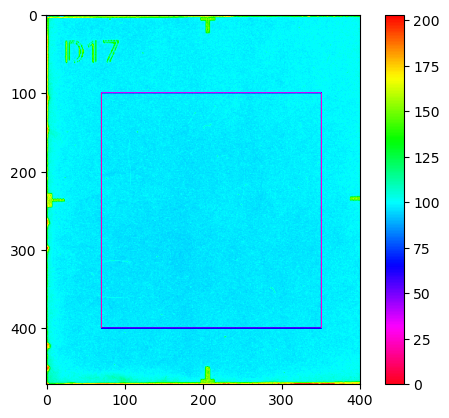

  Mean intensity square :  100.0364880952381


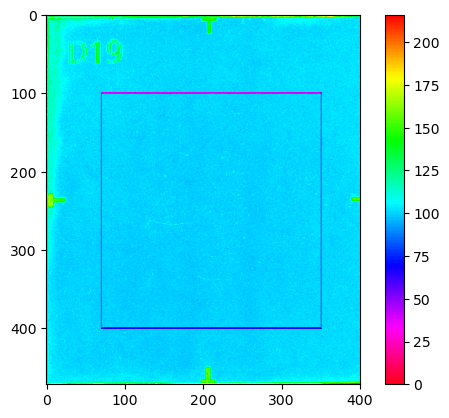

  Mean intensity square :  113.75864285714286


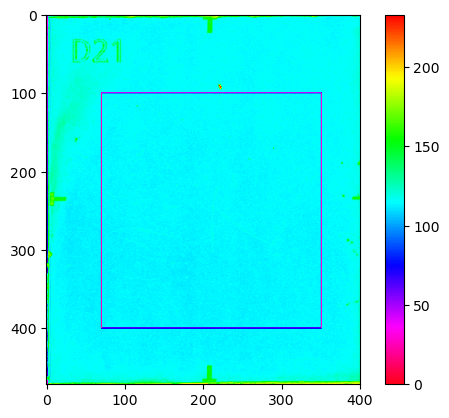

  Mean intensity square :  139.92220238095237


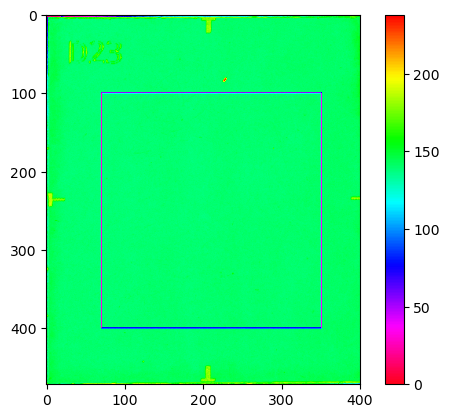

  Mean intensity square :  157.4950357142857


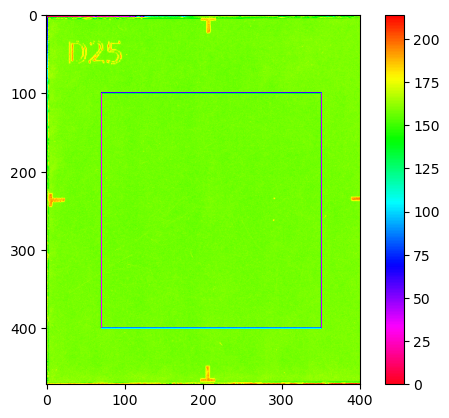

  Mean intensity square :  175.16083333333333


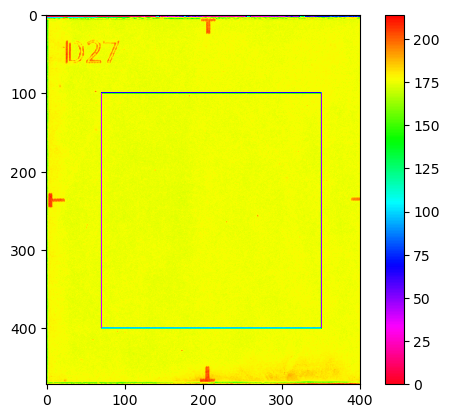

  Mean intensity square :  182.5592619047619


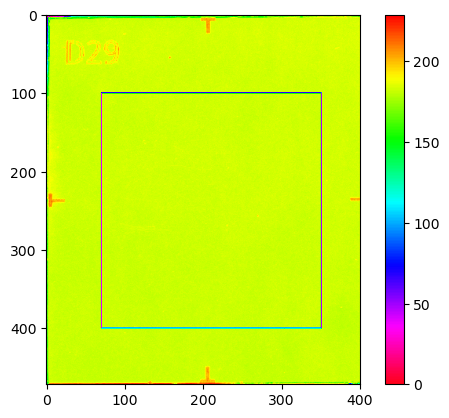

  Mean intensity square :  198.06016666666667


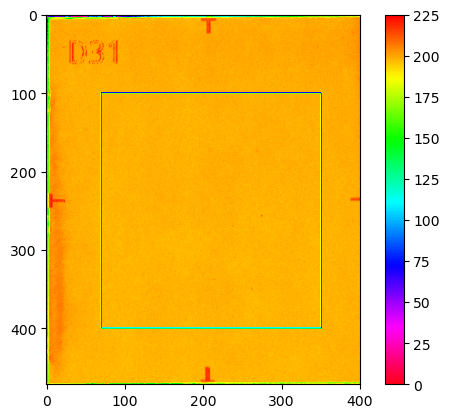

  Mean intensity square :  208.4497738095238


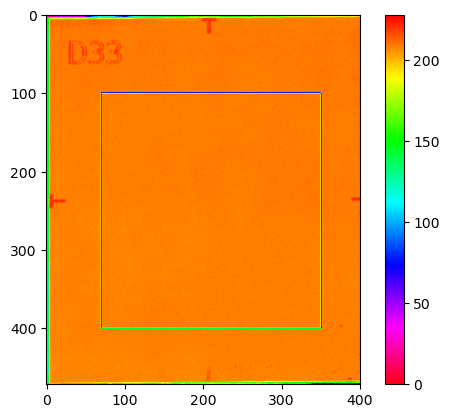

  Mean intensity square :  94.36064285714286


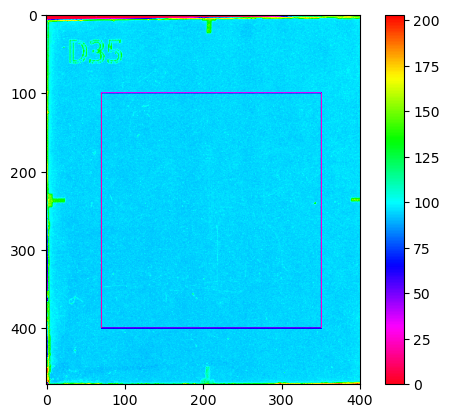

In [89]:
I=[]
n=0

filenames = np.sort(os.listdir(f"calibration/{filmtype}"))


with open(f"calibration/{filmtype}_int.txt", "w") as text_file:                   
    text_file.write("Film \t Intensity\n")                                           
    
    for i in filenames:                                                                     
        file = f'calibration/{filmtype}/{i}'
        column0 = i.replace(".tif", "")
        
        image = cv2.imread(file)
        image_g = image[:,:,1]             
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if channel == "G":
            negative_image = cv2.bitwise_not(image_g)
        elif channel == "RGB":
            negative_image = cv2.bitwise_not(image_gray)
        else:
            print("channel error")
            break
                                                   
                                                                                            
        x, y, width, height = 70, 100, 280, 300                   
        square = negative_image[y:y+height, x:x+width]                                     
        mean_intensity = np.mean(square)    
        
        print(" \033[1m Mean intensity square : \033[0m", mean_intensity)
        
        I.append(mean_intensity)
        
        result = cv2.rectangle(negative_image, (x,y), (x+width, y+height), (0,0,0), 1)
        
        plt.figure()
        plt.imshow(result, cmap="hsv_r")
        plt.colorbar()
        plt.show()                         
        
        line = f"{column0}\t{I[n]}\n"
        
        text_file.write(line)
        
        n+=1
        

## 2. Calibration Curve 


### 2.1 OD calculation

In [90]:
I_sorted = np.sort(I)

OD = []

def ItoOD(x):
    return abs(np.log(min(I_sorted)/x))

for i in I_sorted:
    OD.append(ItoOD(i))

print(OD)

[0.0, 0.027949020370333467, 0.05841093305719269, 0.18695496877591927, 0.3939625035430226, 0.5122698711641548, 0.6185805321464641, 0.6599507757469245, 0.741446789258232, 0.7925740518891774]


### 2.2 Calibration with calculated OD

**Fit model such as :** $$ D(OD) = \frac{a - c e^{-OD}}{e^{-OD}-b}$$

 fit parameters:  a = 3.010365663714559, b = 0.37208878799668194, c = 3.07160190504093


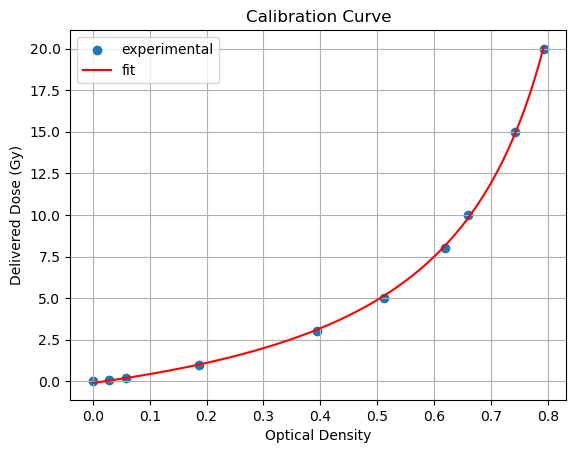

In [91]:
dose_data = np.sort(np.loadtxt(f"calibration/{filmtype}_dose.txt"))

interval = np.linspace(min(OD), max(OD), 100)

def D(x, a, b, c):
    return (a-c*np.exp(-x))/(np.exp(-x)-b)

popt, pcov = curve_fit(D, OD, dose_data, (0, 0, 0), maxfev = 10000)

a, b, c = popt

plt.scatter(OD, dose_data, label='experimental')
plt.plot(interval, D(interval, *popt), label="fit", color="red")
plt.xlabel('Optical Density')
plt.ylabel('Delivered Dose (Gy)')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
print(f"\033[1m fit parameters: \033[0m a = {a}, b = {b}, c = {c}")
plt.show()

## 3. Dose Measurement 

### 3.1 Eppendorf with Mercury to locate the sample

 Mean intensity square :  184.66666666666666 

 Mean dose square :  10.37 Gy 

 gauss parameters hor:  a = 9.67 Gy, sigma = -5.94 mm, mu = 2.28
 gauss parameters ver:  a = 9.66 Gy, sigma = -5.73 mm, mu = 0.93 



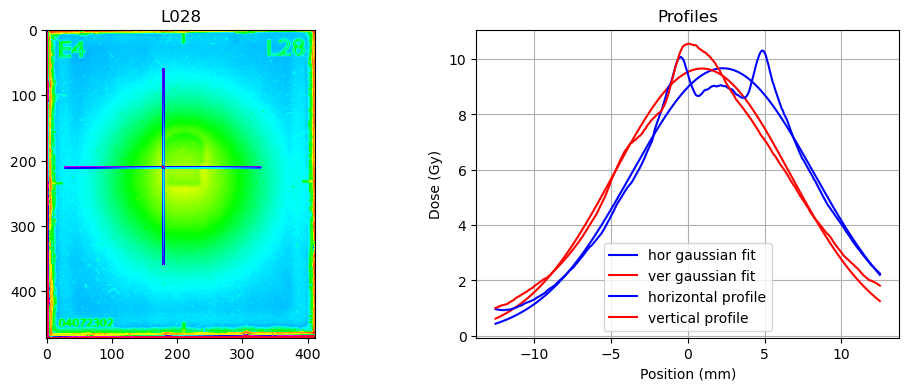

In [98]:
mercury = 'L028'
file = f'HUG_study_2/ZFE_L/{mercury}.tif'

image = cv2.imread(file)

#image specs
height, width, channels = image.shape

mm = round(height/40)   # 1mm in pixel

image_g = image[:, :, 1]
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

if channel == "G":
    negative_image = cv2.bitwise_not(image_g)
elif channel == "RGB":
    negative_image = cv2.bitwise_not(image_gray)
else:
    print("channel error")
        

#Gaussian blur to avoid noise and locate maximum intensity pixel

image_blur = cv2.GaussianBlur(negative_image, (7, 7), 0)

x_zoi, y_zoi = 150, 150

zoi = image_blur[y_zoi:220, x_zoi:220]                  #Defines a restricted search area to better avoid noise

(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(zoi)

#Max pixel coordinates
maxLoc_x = maxLoc[0] + x_zoi
maxLoc_y = maxLoc[1] + y_zoi                     

#Defining Square to measure the dose in

#x, y, width, height = 175, 215, 50, 24                  # -> custom square to fit the mercury
x, y, width, height = maxLoc_x-1, maxLoc_y-1, 3, 3       # -> square on center of mass

area = negative_image[y:y+height, x:x+width]

mean_intensity = np.mean(area)                          #Intensity inside defined square zone


#Profiles

#horizontal slice
x_hor, y_hor, width_hor, height_hor = maxLoc_x-150, maxLoc_y, 300, 2

hor =  negative_image[y_hor:y_hor+height_hor, x_hor:x_hor+width_hor]

#vertical slice
x_ver, y_ver, width_ver, height_ver = maxLoc_x, maxLoc_y-150, 2, 300

ver =  negative_image[y_ver:y_ver+height_ver, x_ver:x_ver+width_ver]

#vertical and horizontal intensity per mm 

ver_intensity = []
hor_intensity = []  

for j in range(1,height_ver):
    ver_intensity.append(np.mean(negative_image[y_ver+j:y_ver+j+mm, x_ver:x_ver+width_ver]))
    
for j in range(1,width_hor):
    hor_intensity.append(np.mean(negative_image[y_hor:y_hor+height_hor, x_hor+j:x_hor+j+mm])) 
    
#vertical and horizontal dose per mm

ver_dose = []
hor_dose = []

for j in range(1, height_ver-1):
    ver_dose.append(D(ItoOD(ver_intensity[j]), *popt))

for j in range(1,width_hor-1) :
    hor_dose.append(D(ItoOD(hor_intensity[j]), *popt))

#Display and Gaussian fit 

result = cv2.rectangle(negative_image, (x,y), (x+width, y+height), (0,255,0), 1)
result_hor = cv2.rectangle(negative_image, (x_hor,y_hor), (x_hor+width_hor, y_hor+height_hor), (0,255,0), 1)
result_ver = cv2.rectangle(negative_image, (x_ver,y_ver), (x_ver+width_ver, y_ver+height_ver), (0,255,0), 1)

print("\033[1m Mean intensity square : \033[0m", mean_intensity, "\n")
print("\033[1m Mean dose square : \033[0m", round(D(ItoOD(mean_intensity), *popt), 2), "Gy \n")

fig, axs = plt.subplots(1,2, figsize=(12, 4))
axs = axs.ravel()

def gauss(x, a, sigma, mu):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

interval = np.linspace(-width_hor/2, width_hor/2, width_hor-2)
interval_mm = interval / mm  

dose = round(D(ItoOD(mean_intensity), *popt), 2)


if dose > 1:
    
    popt_hor, pcov_hor = curve_fit(gauss, interval_mm, hor_dose)
    popt_ver, pcov_ver = curve_fit(gauss, interval_mm, ver_dose)

    a_hor, sigma_hor, mu_hor = popt_hor
    a_ver, sigma_ver, mu_ver = popt_ver

    axs[1].plot(interval_mm, gauss(interval_mm, *popt_hor), "blue",  label="hor gaussian fit")
    axs[1].plot(interval_mm, gauss(interval_mm, *popt_ver), "red",  label="ver gaussian fit")

    print(f"\033[1m gauss parameters hor: \033[0m a = {round(a_hor, 2)} Gy, sigma = {round(sigma_hor, 2)} mm, mu = {round(mu_hor, 2)}")
    print(f"\033[1m gauss parameters ver: \033[0m a = {round(a_ver, 2)} Gy, sigma = {round(sigma_ver, 2)} mm, mu = {round(mu_ver, 2)} \n")


axs[0].imshow(result, cmap="hsv_r")
axs[0].set_title(mercury)

axs[1].plot(interval_mm, hor_dose, color="blue", label="horizontal profile")
axs[1].plot(interval_mm, ver_dose, color="red",  label="vertical profile")
axs[1].set_xlabel("Position (mm)")
axs[1].set_ylabel("Dose (Gy)")
axs[1].set_title("Profiles")
axs[1].grid(True)
axs[1].legend()

plt.show()

## 3.2 Dose measurement of the whole batch

**See txt file attached for listed dose values**

 Mean dose square :  9.52 Gy 

 gauss parameters hor:  a = 8.98 Gy, sigma = -5.4 mm, mu = 0.1
 gauss parameters ver:  a = 9.34 Gy, sigma = -5.38 mm, mu = 1.12 

(maxLoc_x, maxLoc_y) = (196, 210)


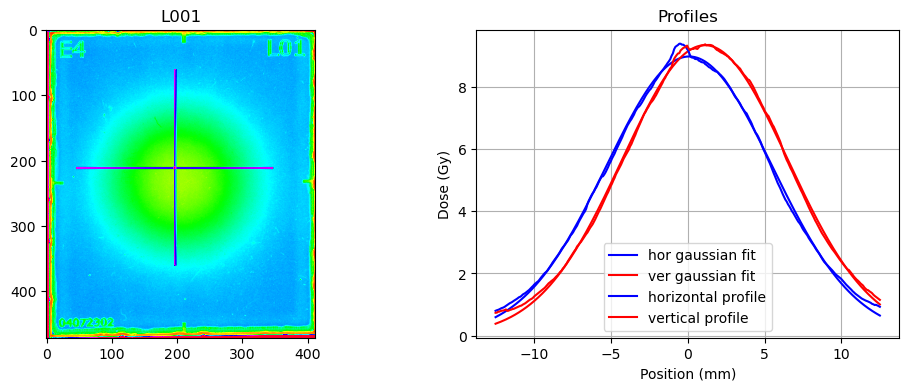

 Mean dose square :  8.1 Gy 

 gauss parameters hor:  a = 7.6 Gy, sigma = 5.84 mm, mu = -0.23
 gauss parameters ver:  a = 7.97 Gy, sigma = 5.86 mm, mu = 1.4 

(maxLoc_x, maxLoc_y) = (203, 208)


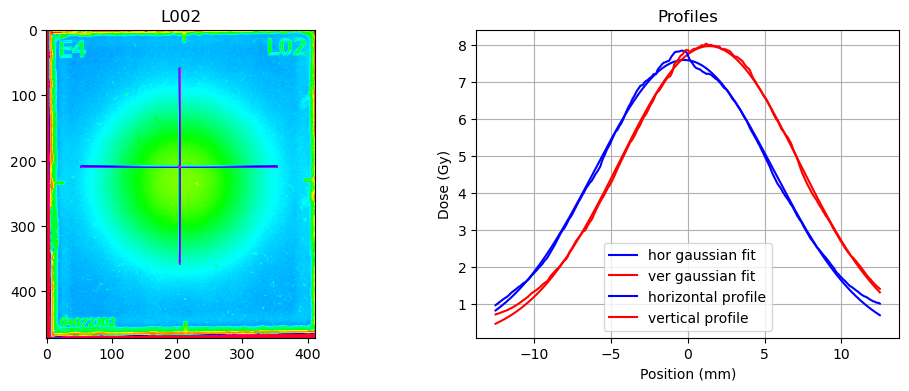

 Mean dose square :  9.44 Gy 

 gauss parameters hor:  a = 9.23 Gy, sigma = -5.35 mm, mu = -0.25
 gauss parameters ver:  a = 9.36 Gy, sigma = -5.39 mm, mu = 0.41 

(maxLoc_x, maxLoc_y) = (202, 218)


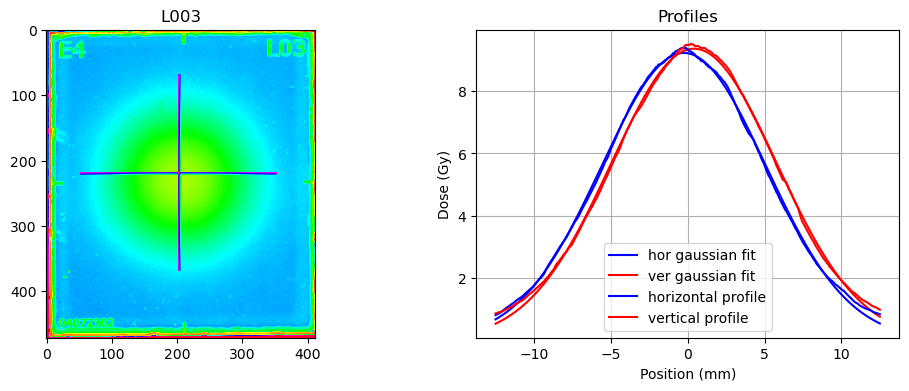

 Mean dose square :  8.08 Gy 

 gauss parameters hor:  a = 7.87 Gy, sigma = 5.75 mm, mu = -0.06
 gauss parameters ver:  a = 8.04 Gy, sigma = 5.75 mm, mu = 0.46 

(maxLoc_x, maxLoc_y) = (201, 216)


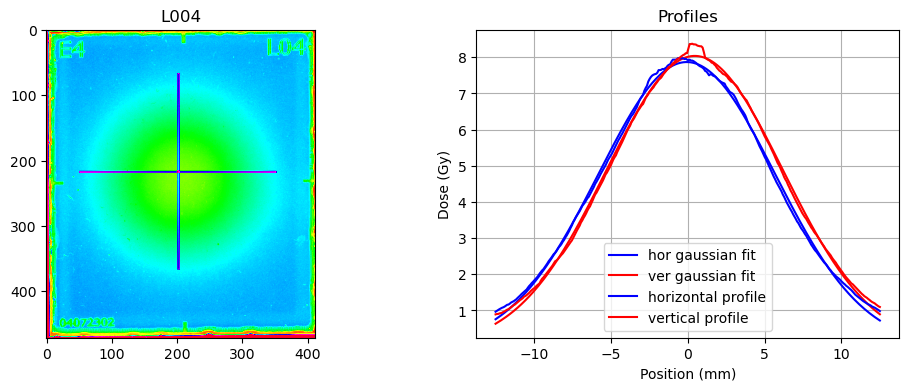

 Mean dose square :  9.36 Gy 

 gauss parameters hor:  a = 9.19 Gy, sigma = -5.41 mm, mu = 0.17
 gauss parameters ver:  a = 9.35 Gy, sigma = -5.4 mm, mu = 0.45 

(maxLoc_x, maxLoc_y) = (197, 218)


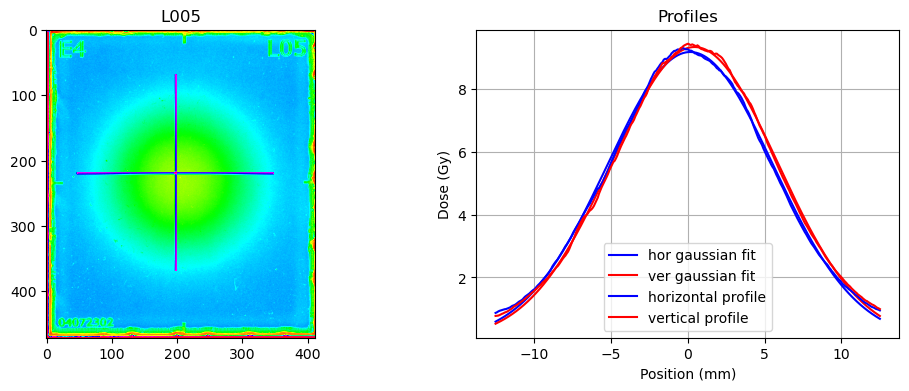

 Mean dose square :  8.03 Gy 

 gauss parameters hor:  a = 7.84 Gy, sigma = 5.85 mm, mu = -0.28
 gauss parameters ver:  a = 8.17 Gy, sigma = 5.86 mm, mu = 0.97 

(maxLoc_x, maxLoc_y) = (205, 210)


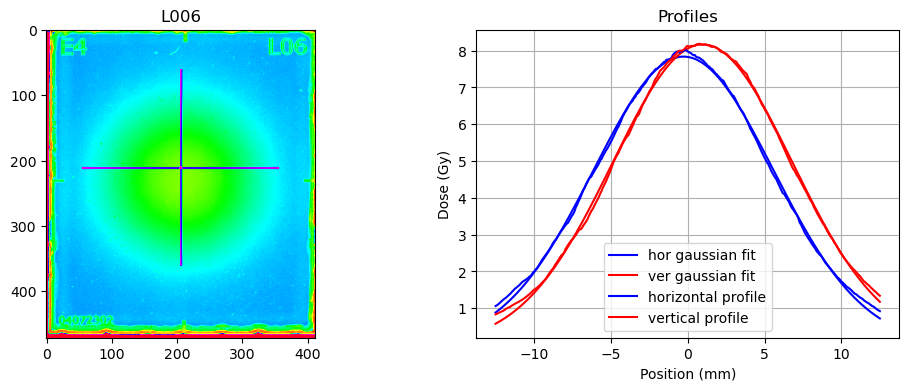

 Mean dose square :  10.43 Gy 

 gauss parameters hor:  a = 10.31 Gy, sigma = 5.37 mm, mu = -0.15
 gauss parameters ver:  a = 10.62 Gy, sigma = 5.34 mm, mu = 0.77 

(maxLoc_x, maxLoc_y) = (199, 216)


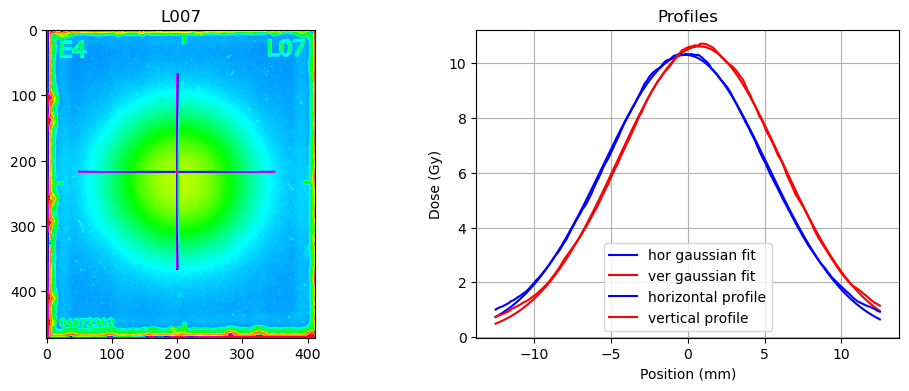

 Mean dose square :  9.39 Gy 

 gauss parameters hor:  a = 9.04 Gy, sigma = -5.83 mm, mu = -0.47
 gauss parameters ver:  a = 9.28 Gy, sigma = -5.83 mm, mu = 0.66 

(maxLoc_x, maxLoc_y) = (206, 217)


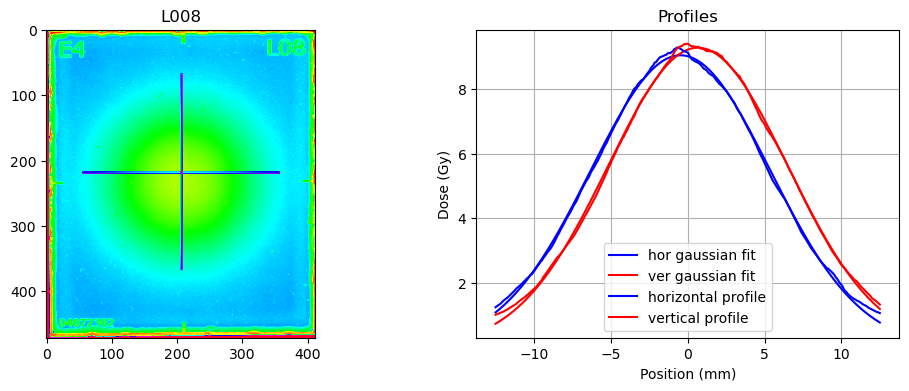

 Mean dose square :  10.65 Gy 

 gauss parameters hor:  a = 10.57 Gy, sigma = 5.46 mm, mu = 0.1
 gauss parameters ver:  a = 10.65 Gy, sigma = 5.41 mm, mu = 0.52 

(maxLoc_x, maxLoc_y) = (199, 216)


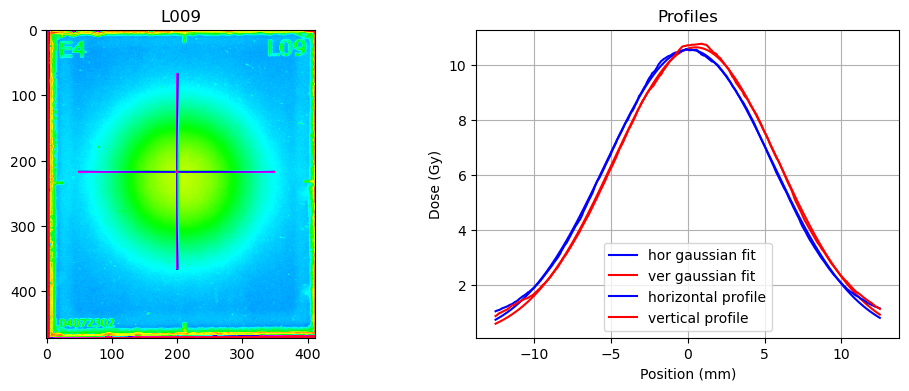

 Mean dose square :  9.36 Gy 

 gauss parameters hor:  a = 9.09 Gy, sigma = -5.85 mm, mu = -0.41
 gauss parameters ver:  a = 9.42 Gy, sigma = -5.82 mm, mu = 0.72 

(maxLoc_x, maxLoc_y) = (207, 216)


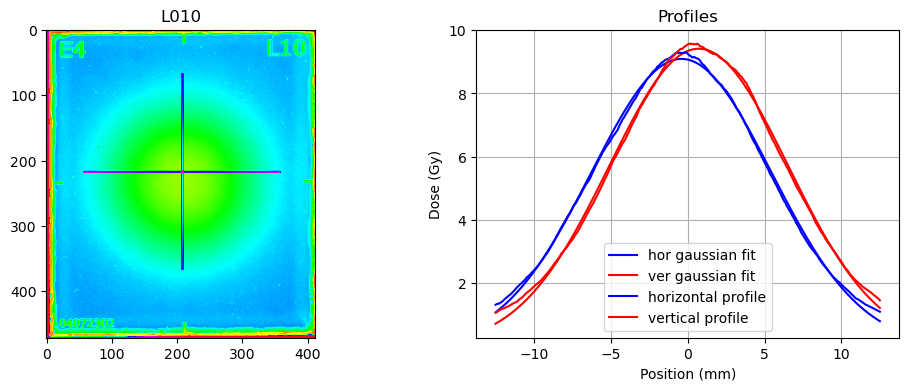

 Mean dose square :  10.68 Gy 

 gauss parameters hor:  a = 10.57 Gy, sigma = 5.44 mm, mu = 0.26
 gauss parameters ver:  a = 10.74 Gy, sigma = 5.4 mm, mu = 0.53 

(maxLoc_x, maxLoc_y) = (190, 216)


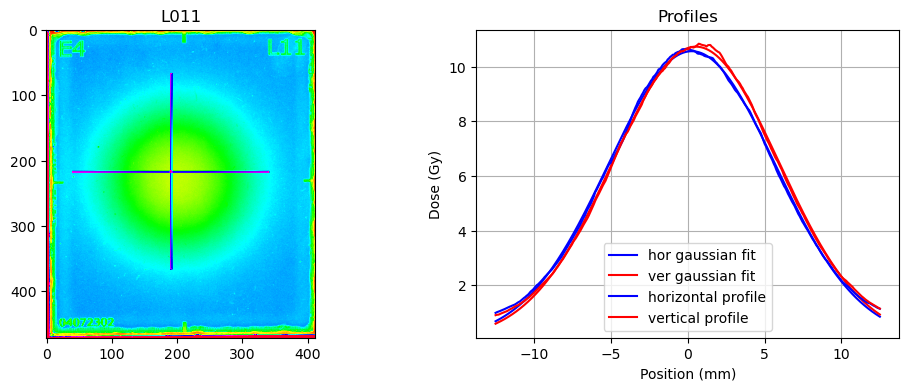

 Mean dose square :  9.31 Gy 

 gauss parameters hor:  a = 9.2 Gy, sigma = -5.92 mm, mu = -0.13
 gauss parameters ver:  a = 9.46 Gy, sigma = -5.9 mm, mu = 0.79 

(maxLoc_x, maxLoc_y) = (197, 218)


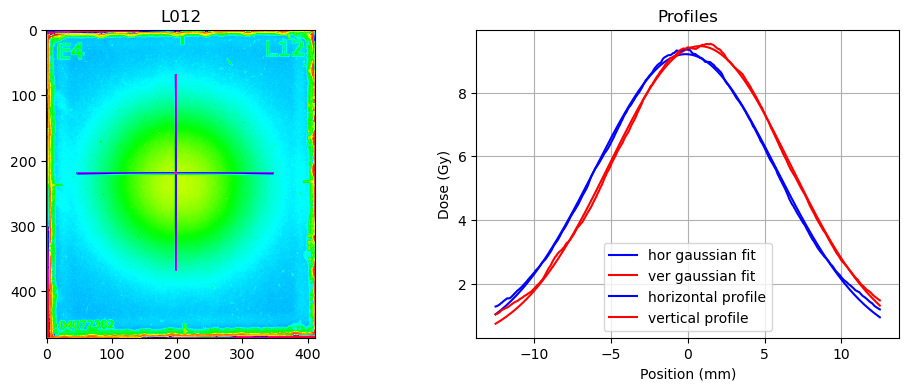

 Mean dose square :  8.26 Gy 

 gauss parameters hor:  a = 8.11 Gy, sigma = 5.76 mm, mu = 0.06
 gauss parameters ver:  a = 8.39 Gy, sigma = 5.71 mm, mu = 0.83 

(maxLoc_x, maxLoc_y) = (195, 213)


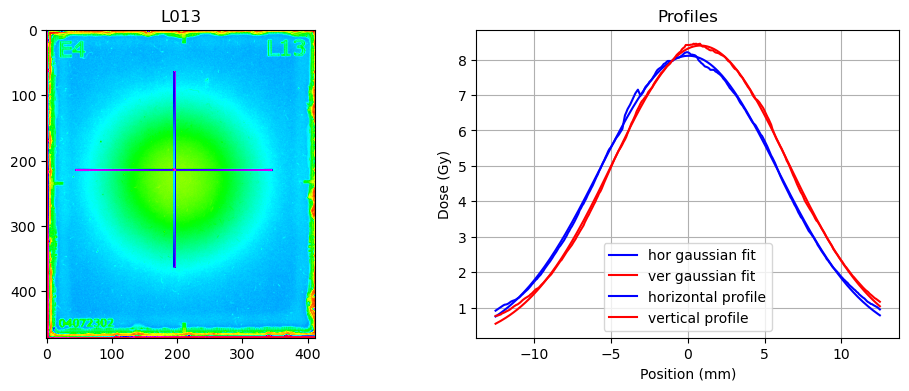

 Mean dose square :  7.28 Gy 

 gauss parameters hor:  a = 7.13 Gy, sigma = 6.05 mm, mu = -0.13
 gauss parameters ver:  a = 7.28 Gy, sigma = 6.06 mm, mu = 0.82 

(maxLoc_x, maxLoc_y) = (202, 212)


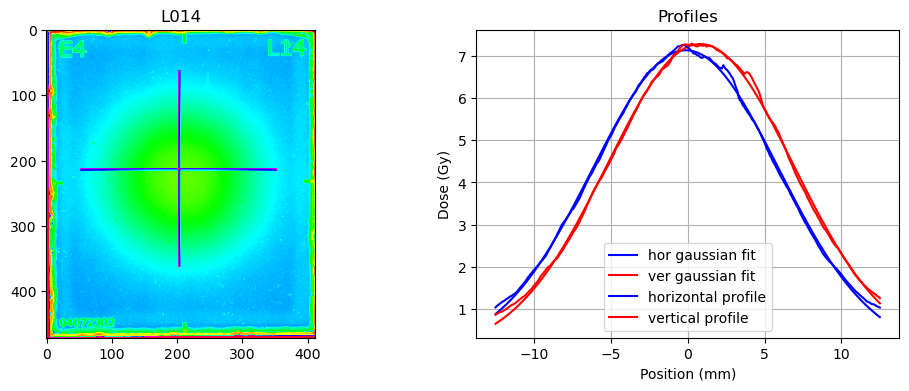

 Mean dose square :  7.83 Gy 

 gauss parameters hor:  a = 7.79 Gy, sigma = 5.66 mm, mu = -0.53
 gauss parameters ver:  a = 7.93 Gy, sigma = 5.63 mm, mu = 0.39 

(maxLoc_x, maxLoc_y) = (209, 214)


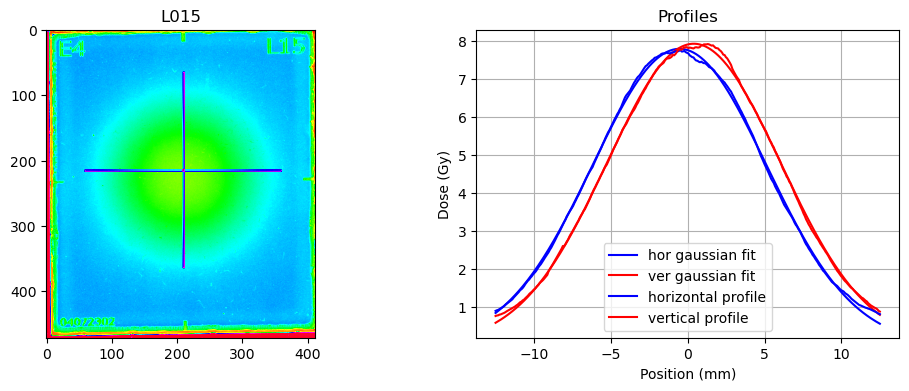

 Mean dose square :  7.09 Gy 

 gauss parameters hor:  a = 6.93 Gy, sigma = 6.08 mm, mu = -0.33
 gauss parameters ver:  a = 6.96 Gy, sigma = 6.06 mm, mu = 0.47 

(maxLoc_x, maxLoc_y) = (211, 215)


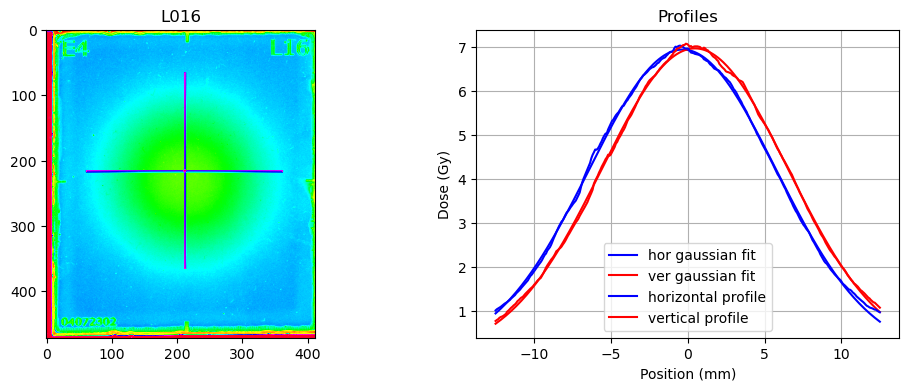

 Mean dose square :  7.88 Gy 

 gauss parameters hor:  a = 7.82 Gy, sigma = 5.68 mm, mu = 0.3
 gauss parameters ver:  a = 7.91 Gy, sigma = 5.61 mm, mu = 0.18 

(maxLoc_x, maxLoc_y) = (197, 219)


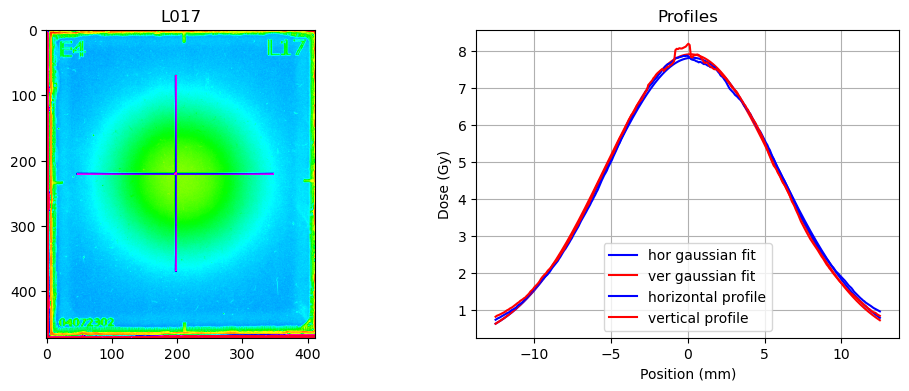

 Mean dose square :  7.09 Gy 

 gauss parameters hor:  a = 6.9 Gy, sigma = 6.06 mm, mu = -0.37
 gauss parameters ver:  a = 7.02 Gy, sigma = 6.02 mm, mu = 0.55 

(maxLoc_x, maxLoc_y) = (208, 216)


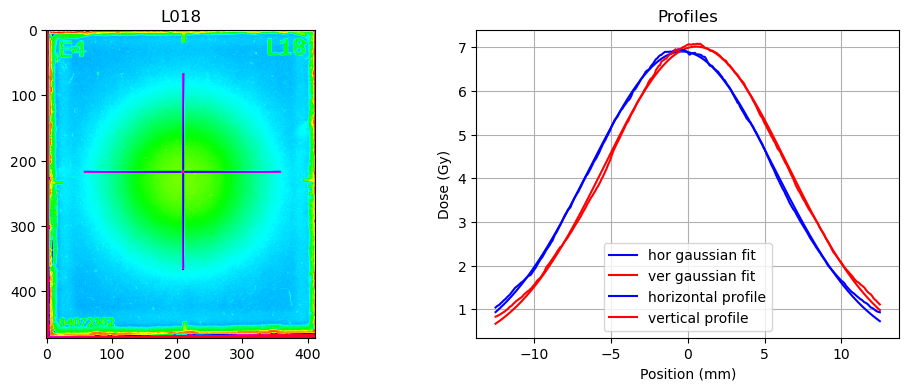

 Mean dose square :  10.23 Gy 

 gauss parameters hor:  a = 10.06 Gy, sigma = 5.69 mm, mu = 0.46
 gauss parameters ver:  a = 10.24 Gy, sigma = 5.67 mm, mu = 0.93 

(maxLoc_x, maxLoc_y) = (194, 210)


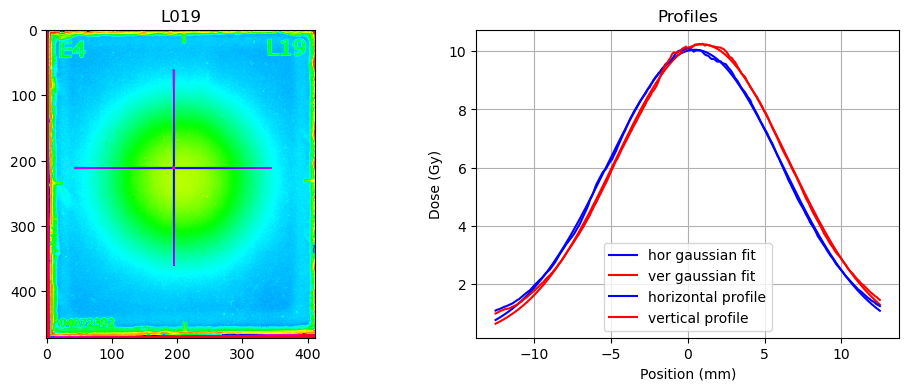

 Mean dose square :  8.72 Gy 

 gauss parameters hor:  a = 8.3 Gy, sigma = 6.05 mm, mu = -0.27
 gauss parameters ver:  a = 8.94 Gy, sigma = 6.06 mm, mu = 1.59 

(maxLoc_x, maxLoc_y) = (206, 204)


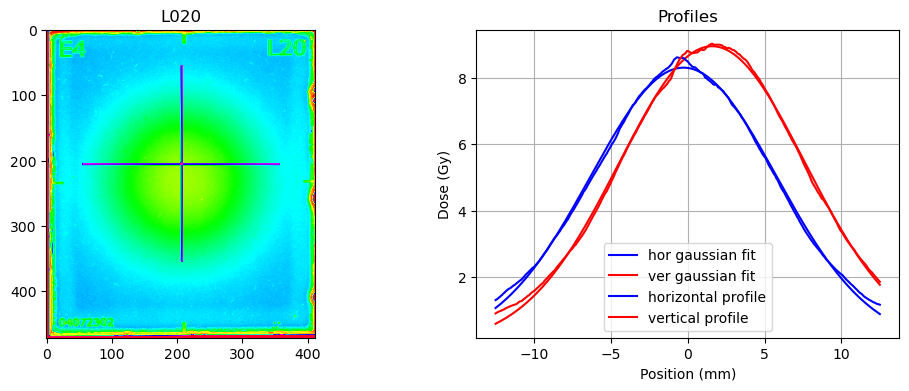

 Mean dose square :  9.91 Gy 

 gauss parameters hor:  a = 9.68 Gy, sigma = -5.67 mm, mu = 0.46
 gauss parameters ver:  a = 9.92 Gy, sigma = -5.67 mm, mu = 0.74 

(maxLoc_x, maxLoc_y) = (193, 212)


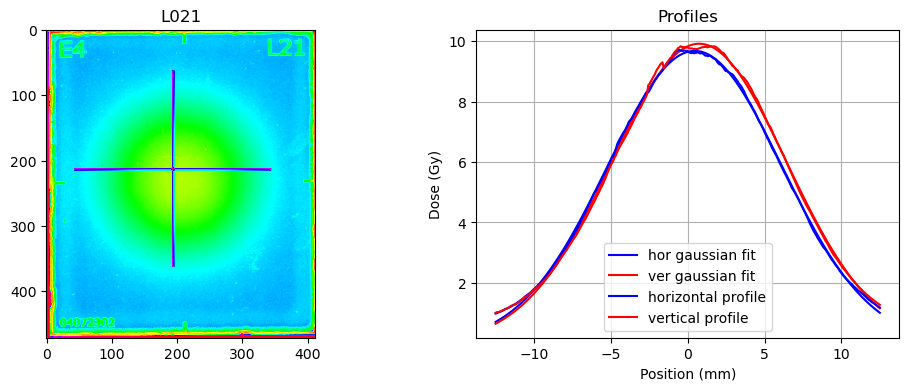

 Mean dose square :  8.43 Gy 

 gauss parameters hor:  a = 8.32 Gy, sigma = 6.04 mm, mu = -0.44
 gauss parameters ver:  a = 8.52 Gy, sigma = 6.06 mm, mu = 0.87 

(maxLoc_x, maxLoc_y) = (205, 213)


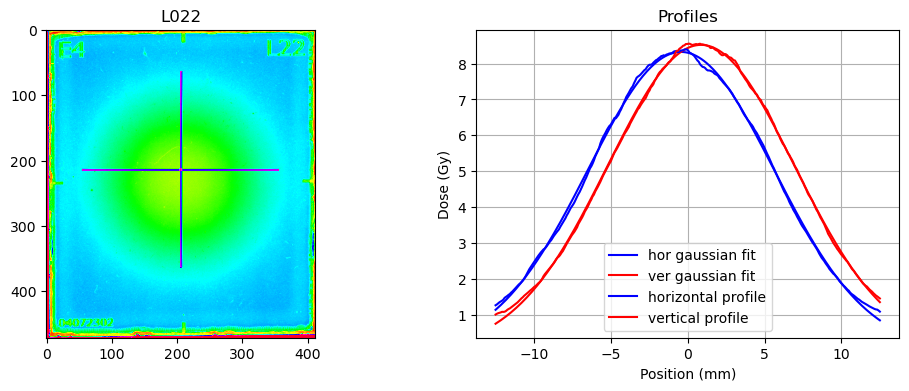

 Mean dose square :  9.94 Gy 

 gauss parameters hor:  a = 9.73 Gy, sigma = -5.72 mm, mu = -0.75
 gauss parameters ver:  a = 9.82 Gy, sigma = -5.68 mm, mu = 0.47 

(maxLoc_x, maxLoc_y) = (206, 217)


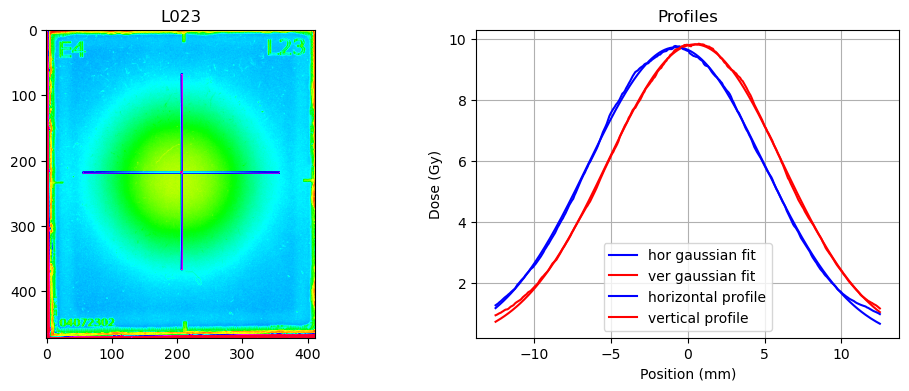

 Mean dose square :  8.77 Gy 

 gauss parameters hor:  a = 8.55 Gy, sigma = 6.17 mm, mu = -0.46
 gauss parameters ver:  a = 8.74 Gy, sigma = 6.17 mm, mu = 0.71 

(maxLoc_x, maxLoc_y) = (205, 214)


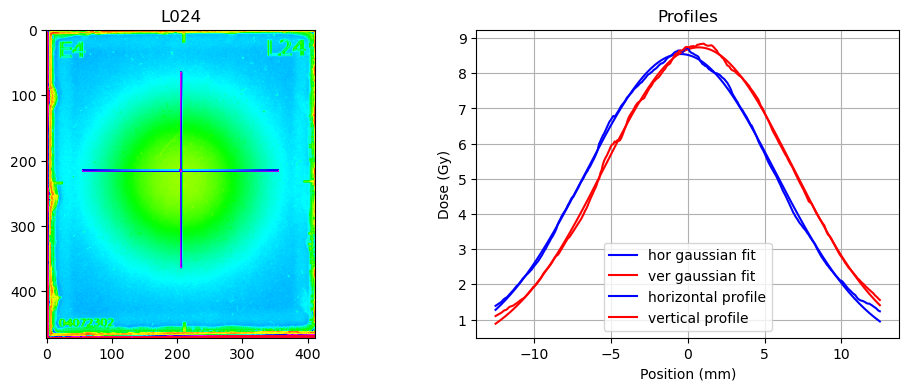

 Mean dose square :  10.68 Gy 

 gauss parameters hor:  a = 10.47 Gy, sigma = -5.53 mm, mu = -1.38
 gauss parameters ver:  a = 10.7 Gy, sigma = 5.5 mm, mu = 0.84 

(maxLoc_x, maxLoc_y) = (214, 213)


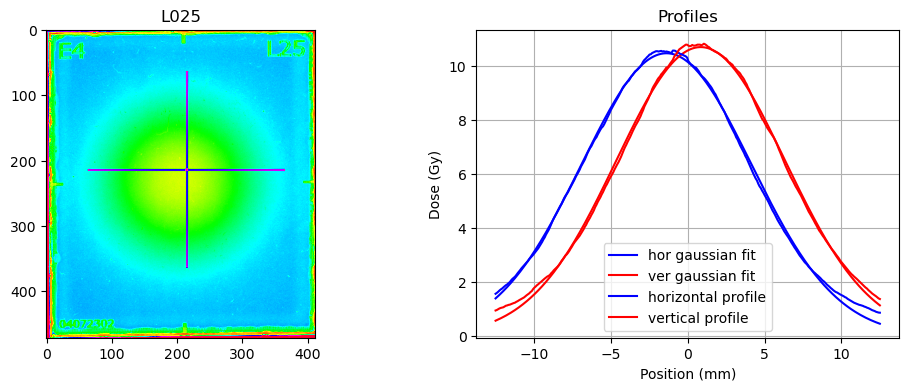

 Mean dose square :  11.28 Gy 

 gauss parameters hor:  a = 10.45 Gy, sigma = 5.72 mm, mu = 1.74
 gauss parameters ver:  a = 9.93 Gy, sigma = -5.67 mm, mu = 0.61 

(maxLoc_x, maxLoc_y) = (180, 214)


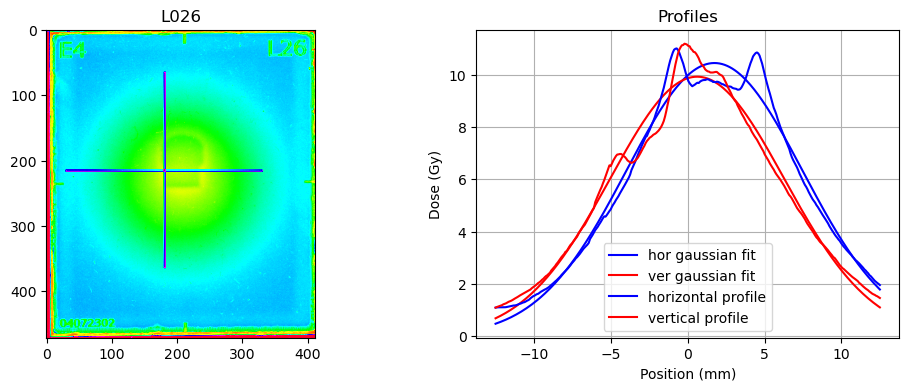

 Mean dose square :  10.05 Gy 

 gauss parameters hor:  a = 10.02 Gy, sigma = -5.71 mm, mu = -0.03
 gauss parameters ver:  a = 10.23 Gy, sigma = -5.73 mm, mu = 0.35 

(maxLoc_x, maxLoc_y) = (206, 219)


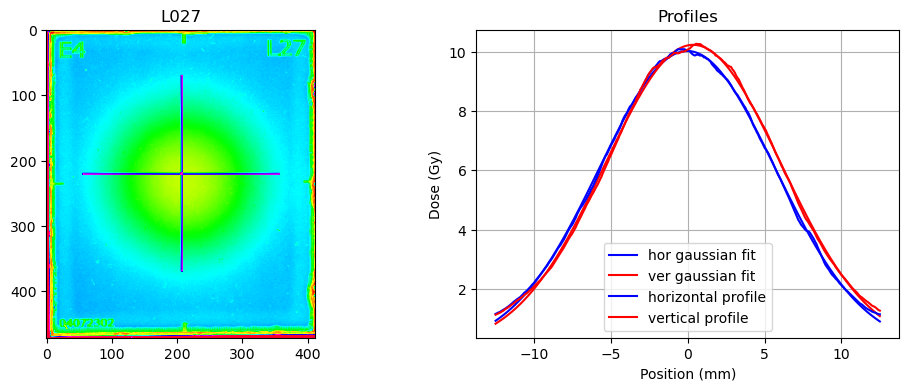

 Mean dose square :  10.52 Gy 

 gauss parameters hor:  a = 9.74 Gy, sigma = -5.92 mm, mu = 2.14
 gauss parameters ver:  a = 9.56 Gy, sigma = -5.8 mm, mu = 1.0 

(maxLoc_x, maxLoc_y) = (180, 210)


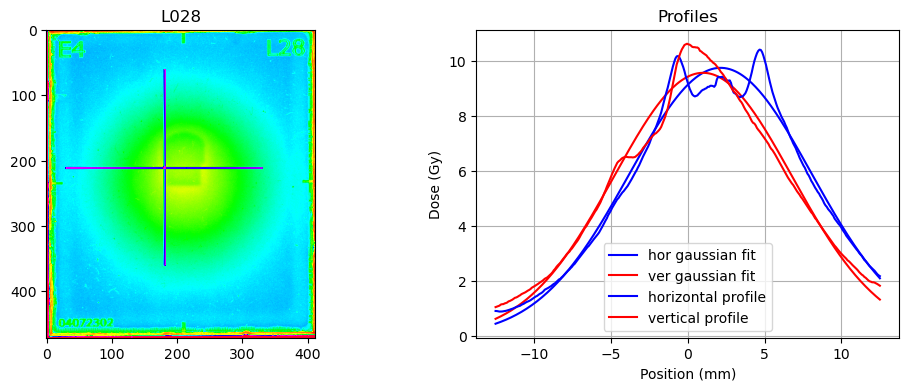

 Mean dose square :  0.19 Gy 

(maxLoc_x, maxLoc_y) = (202, 191)


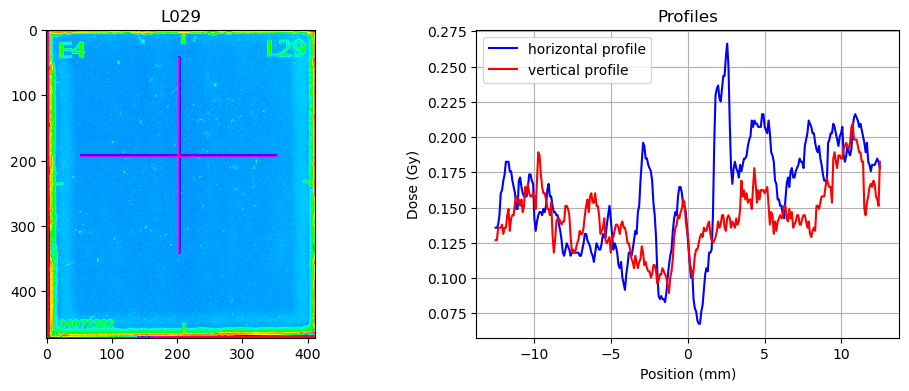

 Mean dose square :  0.25 Gy 

(maxLoc_x, maxLoc_y) = (180, 180)


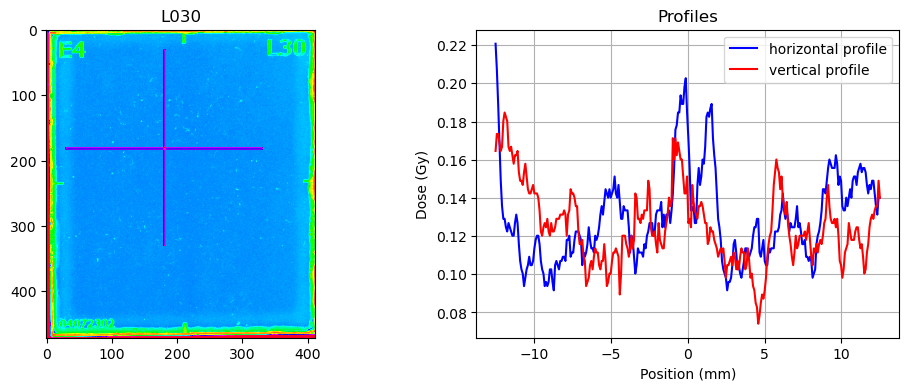

 Mean dose square :  0.42 Gy 

(maxLoc_x, maxLoc_y) = (217, 217)


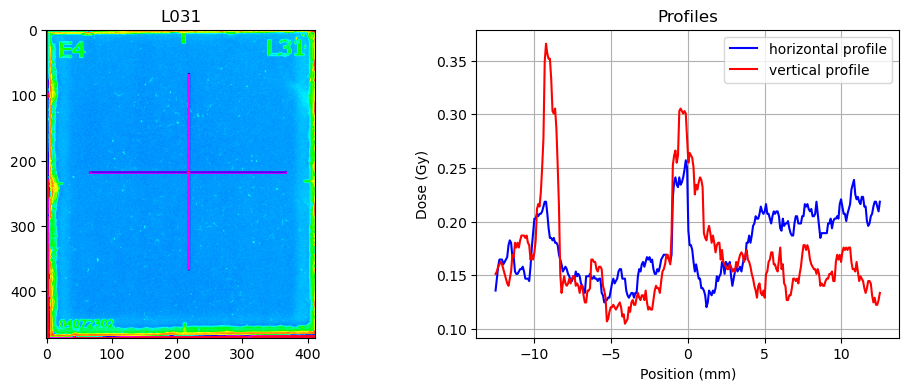

 Mean dose square :  0.43 Gy 

(maxLoc_x, maxLoc_y) = (211, 180)


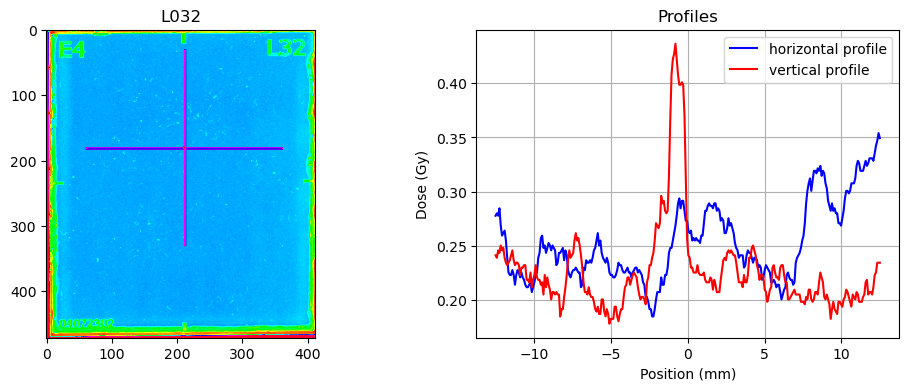

In [96]:
letter = "L"

filenames = np.sort(os.listdir(f"HUG_study_2/ZFE_{letter}"))

dose = []
I = []

n=0
with open(f"cuvette/measured_dose_{letter}.txt", "w") as text_file:
    text_file.write("Film \t Dose (Gy)\n")

    for i in filenames:    
    
        file = f'HUG_study_2/ZFE_{letter}/{i}'
        column0 = i.replace(".tif", "")
        
        image = cv2.imread(file)
        
        #image specs
        height, width, channels = image.shape

        mm = round(height/40)   # 1mm in pixel

        image_g = image[:, :, 1]
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        if channel == "G":
            negative_image = cv2.bitwise_not(image_g)
        elif channel == "RGB":
            negative_image = cv2.bitwise_not(image_gray)
        else:
            print("channel error")
            break


        #Gaussian blur to avoid noise and locate maximum intensity pixel

        image_blur = cv2.GaussianBlur(negative_image, (7, 7), 0)

        x_zoi, y_zoi = 180, 180

        zoi = image_blur[y_zoi:220, x_zoi:220]                  #Defines a restricted search area to better avoid noise

        (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(zoi)

        #Max pixel coordinates
        maxLoc_x = maxLoc[0] + x_zoi
        maxLoc_y = maxLoc[1] + y_zoi                     

        #Defining Square to measure the dose in

        #x, y, width, height = 175, 215, 50, 24                  # -> custom square
        x, y, width, height = maxLoc_x-1, maxLoc_y-1, 3, 3       # -> square on center of mass

        area = negative_image[y:y+height, x:x+width]

        mean_intensity = np.mean(area)                          #Intensity inside defined square zone
        
        
        #Profiles
        #horizontal slice
        x_hor, y_hor, width_hor, height_hor = maxLoc_x-150, maxLoc_y, 300, 2
        hor =  negative_image[y_hor:y_hor+height_hor, x_hor:x_hor+width_hor]

        #vertical slice
        x_ver, y_ver, width_ver, height_ver = maxLoc_x, maxLoc_y-150, 2, 300
        ver =  negative_image[y_ver:y_ver+height_ver, x_ver:x_ver+width_ver]
        
        
        #vertical and horizontal intensity per pixel length

        hor_intensity = []
        ver_intensity = []
        
        for j in range(1,width_hor):
            hor_intensity.append(np.mean(negative_image[y_hor:y_hor+height_hor, x_hor+j:x_hor+j+12]))   

        for j in range(1,height_ver):
            ver_intensity.append(np.mean(negative_image[y_ver+j:y_ver+j+12, x_ver:x_ver+width_ver]))
        
        #vertical and horizontal dose per pixel length
        
        hor_dose = []
        ver_dose = []

        for j in range(1, width_hor-1) :
            hor_dose.append(D(ItoOD(hor_intensity[j]), *popt))
            
        for j in range(1, height_ver-1):
            ver_dose.append(D(ItoOD(ver_intensity[j]), *popt))

        #Display and Gaussian fit
        
        result = cv2.rectangle(negative_image, (x,y), (x+width, y+height), (0,255,0), 1)
        result_hor = cv2.rectangle(negative_image, (x_hor,y_hor), (x_hor+width_hor, y_hor+height_hor), (0,255,0), 1)
        result_ver = cv2.rectangle(negative_image, (x_ver,y_ver), (x_ver+width_ver, y_ver+height_ver), (0,255,0), 1)
        
        #print("\033[1m Mean intensity square : \033[0m", mean_intensity, "\n")
        print(f"\033[1m Mean dose square : \033[0m", round(D(ItoOD(mean_intensity), *popt), 2), "Gy \n")
        
        interval = np.linspace(-width_hor/2, width_hor/2, width_hor-2)
        interval_mm = interval/12  #Conversion en millimètres
        
        fig, axs = plt.subplots(1,2, figsize=(12, 4))
        axs = axs.ravel()
        
        def gauss(x, a, sigma, mu):
            return a*np.exp(-(x-mu)**2/(2*sigma**2))

        dose.append(round(D(ItoOD(mean_intensity), *popt), 2))
        
        if dose[n] > 1:
        
            popt_hor, pcov_hor = curve_fit(gauss, interval_mm, hor_dose)
            popt_ver, pcov_ver = curve_fit(gauss, interval_mm, ver_dose)

            a_hor, sigma_hor, mu_hor = popt_hor
            a_ver, sigma_ver, mu_ver = popt_ver

            axs[1].plot(interval_mm, gauss(interval_mm, *popt_hor), "blue",  label="hor gaussian fit")
            axs[1].plot(interval_mm, gauss(interval_mm, *popt_ver), "red",  label="ver gaussian fit")

            print(f"\033[1m gauss parameters hor: \033[0m a = {round(a_hor, 2)} Gy, sigma = {round(sigma_hor, 2)} mm, mu = {round(mu_hor, 2)}")
            print(f"\033[1m gauss parameters ver: \033[0m a = {round(a_ver, 2)} Gy, sigma = {round(sigma_ver, 2)} mm, mu = {round(mu_ver, 2)} \n")
        

        axs[0].imshow(result, cmap="hsv_r")
        axs[0].set_title(column0)

        axs[1].plot(interval_mm, hor_dose, color="blue", label="horizontal profile")
        axs[1].plot(interval_mm, ver_dose, color="red",  label="vertical profile")
        axs[1].set_xlabel("Position (mm)")
        axs[1].set_ylabel("Dose (Gy)")
        axs[1].set_title("Profiles")
        axs[1].grid(True)
        axs[1].legend()
        
        print("(maxLoc_x, maxLoc_y) =", (maxLoc_x, maxLoc_y))
        plt.show()
        
        #file
        
        I.append(mean_intensity)
        column1 = f"{round(D(ItoOD(mean_intensity), *popt), 2)}"
        #column2 = f"{round(sigma_hor, 2)}"
        
        line = f"{column0}\t {column1} \n"
        
        text_file.write(line)
        
        n+=1